In [ ]:
"""
Digit Recognition with Scikit-learn and PyTorch

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/your_colab_link_here 
"""

'\nDigit Recognition with Scikit-learn and PyTorch\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/your_colab_link_here # Replace with actual link after saving\n'

In [1]:
from IPython.display import clear_output



clear_output()

# Introduction
## Tutorial: Building Machine Learning Models for Handwritten Digit Recognition

**Goal:** This notebook walks through training several machine learning models to recognize handwritten digits (0-9) using the popular `load_digits` dataset from Scikit-learn.

**Dataset:** The `load_digits` dataset contains 1797 images, each an 8x8 grayscale representation of a handwritten digit. Each image is flattened into a 64-feature vector.

**Models We'll Build:**
1.  **Logistic Regression:** A simple, interpretable linear model.
2.  **Random Forest:** An ensemble method based on decision trees, often robust and high-performing.
3.  **Gradient Boosting (GBDT):** Another powerful ensemble method that builds trees sequentially.
4.  **Neural Network (PyTorch):** A simple feed-forward neural network implemented using PyTorch.

**Evaluation:** We will evaluate models based on accuracy, classification reports, and confusion matrices.

**Outcome:** By the end, we will have trained and evaluated these models and saved one for use in a Streamlit visualization app.

In [ ]:
# @title 2. Setup: Import Libraries
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import joblib # For saving sklearn models and scaler
import os # For creating directories

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
# @title 3. Load and Explore the Dataset
# Load the dataset
digits = load_digits()
X, y = digits.data, digits.target

In [ ]:
# Print basic information
print(f"Data shape (X): {X.shape}") # (1797 samples, 64 features)
print(f"Target shape (y): {y.shape}") # (1797 labels)
print(f"Number of unique classes: {len(np.unique(y))}") # 10 classes (0-9)
print(f"Feature names (pixel indices): {digits.feature_names}") # Not very informative here
print(f"Target names (digits): {digits.target_names}")

Data shape (X): (1797, 64)
Target shape (y): (1797,)
Number of unique classes: 10
Feature names (pixel indices): ['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_4', 'pixel_0_5', 'pixel_0_6', 'pixel_0_7', 'pixel_1_0', 'pixel_1_1', 'pixel_1_2', 'pixel_1_3', 'pixel_1_4', 'pixel_1_5', 'pixel_1_6', 'pixel_1_7', 'pixel_2_0', 'pixel_2_1', 'pixel_2_2', 'pixel_2_3', 'pixel_2_4', 'pixel_2_5', 'pixel_2_6', 'pixel_2_7', 'pixel_3_0', 'pixel_3_1', 'pixel_3_2', 'pixel_3_3', 'pixel_3_4', 'pixel_3_5', 'pixel_3_6', 'pixel_3_7', 'pixel_4_0', 'pixel_4_1', 'pixel_4_2', 'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_4_6', 'pixel_4_7', 'pixel_5_0', 'pixel_5_1', 'pixel_5_2', 'pixel_5_3', 'pixel_5_4', 'pixel_5_5', 'pixel_5_6', 'pixel_5_7', 'pixel_6_0', 'pixel_6_1', 'pixel_6_2', 'pixel_6_3', 'pixel_6_4', 'pixel_6_5', 'pixel_6_6', 'pixel_6_7', 'pixel_7_0', 'pixel_7_1', 'pixel_7_2', 'pixel_7_3', 'pixel_7_4', 'pixel_7_5', 'pixel_7_6', 'pixel_7_7']
Target names (digits): [0 1 2 3 4 5 6 7 8 9]


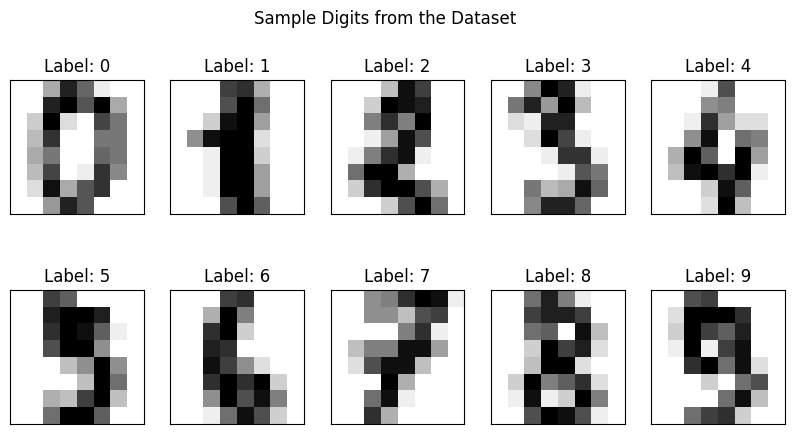

In [ ]:
# Visualize some sample digits
fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(8, 8), cmap='binary', interpolation='nearest')
    ax.set_title(f"Label: {y[i]}")
plt.suptitle("Sample Digits from the Dataset")
plt.show()

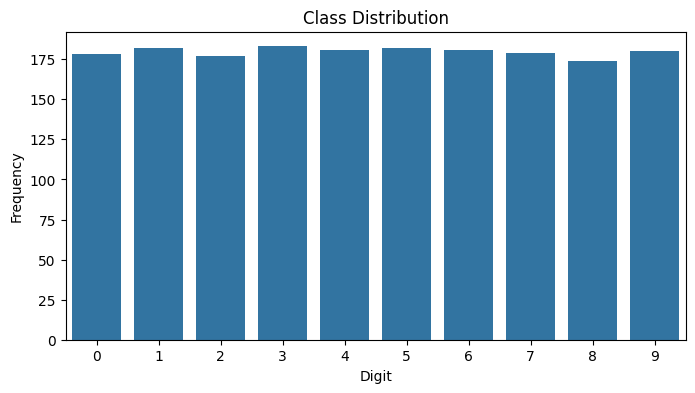

In [ ]:
# Check class distribution
unique, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(8, 4))
sns.barplot(x=unique, y=counts)
plt.title('Class Distribution')
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.show()
# The dataset is fairly balanced.

In [ ]:
# @title 4. Data Preprocessing: Splitting and Scaling
# Split data into training and testing sets (80% train, 20% test)
# Use stratify=y to ensure the proportion of classes is the same in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (1437, 64)
Testing data shape: (360, 64)
Training labels shape: (1437,)
Testing labels shape: (360,)


In [ ]:
# --- Scaling ---
# Scale the features (pixels) to have zero mean and unit variance.
# This is important for Logistic Regression and Neural Networks.
# It generally doesn't hurt tree-based models either.
scaler = StandardScaler()

In [ ]:
# Fit the scaler ONLY on the training data
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
# Transform both the training and testing data using the fitted scaler
X_test_scaled = scaler.transform(X_test)

Tree-based models (Random Forest, GBDT) are less sensitive to feature scaling,
but we'll use the scaled data for consistency and because it's crucial for others.

In [ ]:
# --- Prepare Data for PyTorch ---
# Convert numpy arrays to PyTorch tensors
# Use scaled data for consistency
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long) # CrossEntropyLoss expects long integers for labels
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
# Create TensorDatasets and DataLoaders for batching
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

5. Model Training and Evaluation

In [ ]:
# Helper function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

In [ ]:
# Store results for comparison
model_results = {}

In [ ]:
# --- 5.1 Logistic Regression ---
print("\n--- Training Logistic Regression ---")
log_reg = LogisticRegression(max_iter=1000, random_state=42) # Increased max_iter for convergence


--- Training Logistic Regression ---


In [ ]:
# Train the model on scaled data
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Make predictions on the scaled test data
y_pred_log_reg = log_reg.predict(X_test_scaled)

In [ ]:
# Evaluate the model
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
report_log_reg = classification_report(y_test, y_pred_log_reg, target_names=[str(i) for i in digits.target_names])
model_results['Logistic Regression'] = accuracy_log_reg

Logistic Regression Accuracy: 0.9722
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.89      0.89      0.89        36
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        37
           4       0.97      1.00      0.99        36
           5       1.00      1.00      1.00        37
           6       1.00      0.97      0.99        36
           7       1.00      1.00      1.00        36
           8       0.89      0.89      0.89        35
           9       1.00      0.97      0.99        36

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



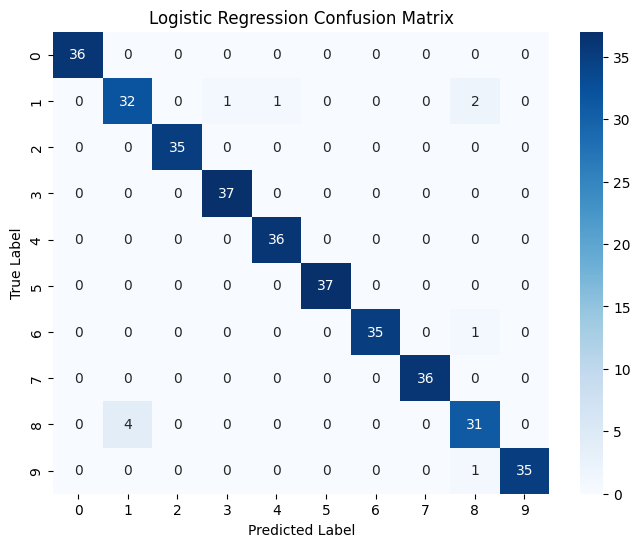

In [ ]:
print(f"Logistic Regression Accuracy: {accuracy_log_reg:.4f}")
print("Classification Report:\n", report_log_reg)
plot_confusion_matrix(y_test, y_pred_log_reg, digits.target_names, title='Logistic Regression Confusion Matrix')

In [ ]:
# --- 5.2 Random Forest ---
print("\n--- Training Random Forest ---")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores


--- Training Random Forest ---


In [ ]:
# Train the model (can use scaled or unscaled, results might differ slightly)
# We'll use scaled here for consistency, though RF isn't sensitive to it.
rf_clf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
# Make predictions
y_pred_rf = rf_clf.predict(X_test_scaled)

In [ ]:
# Evaluate
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, target_names=[str(i) for i in digits.target_names])
model_results['Random Forest'] = accuracy_rf

Random Forest Accuracy: 0.9639
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        36
           1       0.92      0.97      0.95        36
           2       1.00      0.97      0.99        35
           3       0.97      0.97      0.97        37
           4       0.97      1.00      0.99        36
           5       0.97      1.00      0.99        37
           6       1.00      0.97      0.99        36
           7       0.92      1.00      0.96        36
           8       0.94      0.86      0.90        35
           9       0.97      0.92      0.94        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



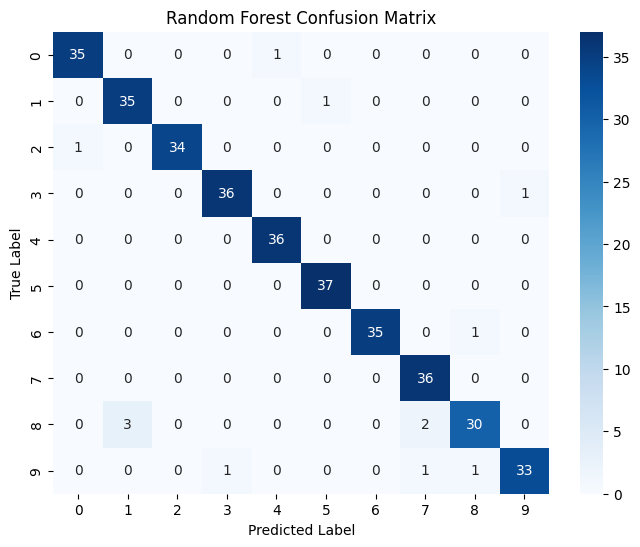

In [ ]:
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("Classification Report:\n", report_rf)
plot_confusion_matrix(y_test, y_pred_rf, digits.target_names, title='Random Forest Confusion Matrix')

In [ ]:
# --- 5.3 Gradient Boosting (GBDT) ---
print("\n--- Training Gradient Boosting (GBDT) ---")
gbdt_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)


--- Training Gradient Boosting (GBDT) ---


In [ ]:
# Train the model
gbdt_clf.fit(X_train_scaled, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
# Make predictions
y_pred_gbdt = gbdt_clf.predict(X_test_scaled)

In [ ]:
# Evaluate
accuracy_gbdt = accuracy_score(y_test, y_pred_gbdt)
report_gbdt = classification_report(y_test, y_pred_gbdt, target_names=[str(i) for i in digits.target_names])
model_results['Gradient Boosting'] = accuracy_gbdt

Gradient Boosting Accuracy: 0.9528
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        36
           1       0.94      0.83      0.88        36
           2       0.97      0.97      0.97        35
           3       0.97      1.00      0.99        37
           4       1.00      0.97      0.99        36
           5       0.97      1.00      0.99        37
           6       0.97      0.94      0.96        36
           7       0.92      1.00      0.96        36
           8       0.89      0.91      0.90        35
           9       0.94      0.92      0.93        36

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360



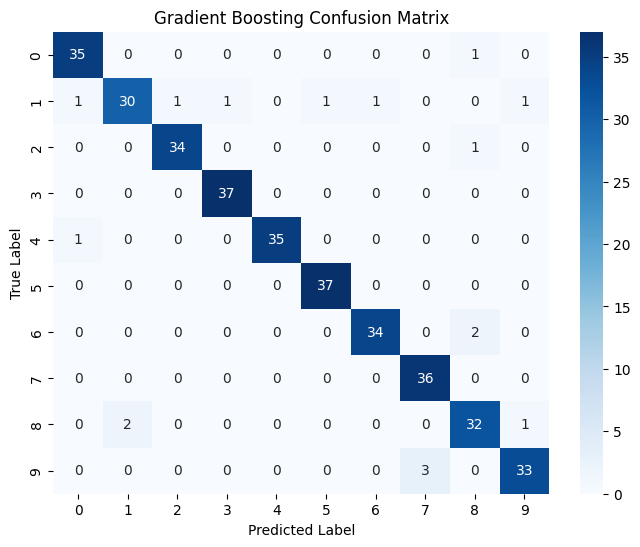

In [ ]:
print(f"Gradient Boosting Accuracy: {accuracy_gbdt:.4f}")
print("Classification Report:\n", report_gbdt)
plot_confusion_matrix(y_test, y_pred_gbdt, digits.target_names, title='Gradient Boosting Confusion Matrix')

In [ ]:
# --- 5.4 Neural Network (PyTorch) ---
print("\n--- Training Neural Network (PyTorch) ---")


--- Training Neural Network (PyTorch) ---


In [ ]:
# Define the neural network architecture
class DigitClassifier(nn.Module):
    def __init__(self, input_size=64, num_classes=10):
        super(DigitClassifier, self).__init__()
        self.layer_1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.layer_2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(64, num_classes)
        # Note: No Softmax here because CrossEntropyLoss combines LogSoftmax and NLLLoss

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu1(x)
        x = self.layer_2(x)
        x = self.relu2(x)
        x = self.output_layer(x)
        return x

In [ ]:
# Instantiate the model, define loss function and optimizer
input_size = X_train_scaled.shape[1] # Should be 64
num_classes = len(digits.target_names) # Should be 10
pytorch_model = DigitClassifier(input_size, num_classes)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)

In [ ]:
# Check for GPU availability and move model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
pytorch_model.to(device)

Using device: cpu


DigitClassifier(
  (layer_1): Linear(in_features=64, out_features=128, bias=True)
  (relu1): ReLU()
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output_layer): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
# Training loop
num_epochs = 30
train_losses = []
train_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    pytorch_model.train() # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = pytorch_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    if (epoch + 1) % 5 == 0: # Print progress every 5 epochs
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

Epoch [5/30], Loss: 0.1832, Accuracy: 0.9589
Epoch [10/30], Loss: 0.0464, Accuracy: 0.9930
Epoch [15/30], Loss: 0.0180, Accuracy: 0.9986
Epoch [20/30], Loss: 0.0088, Accuracy: 1.0000
Epoch [25/30], Loss: 0.0052, Accuracy: 1.0000
Epoch [30/30], Loss: 0.0033, Accuracy: 1.0000


In [ ]:
print('Finished Training')

Finished Training


Text(0, 0.5, 'Loss')

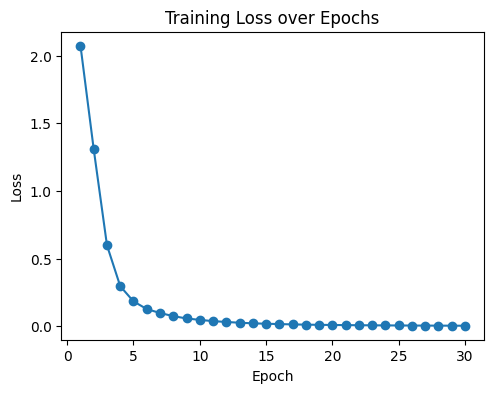

In [ ]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

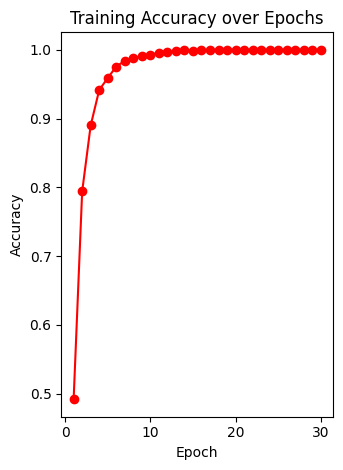

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', color='r')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [ ]:
# --- Evaluate PyTorch Model ---
pytorch_model.eval() # Set model to evaluation mode
all_preds_pt = []
all_labels_pt = []

In [ ]:
with torch.no_grad(): # No need to track gradients during evaluation
    correct_test = 0
    total_test = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pytorch_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_preds_pt.extend(predicted.cpu().numpy()) # Move predictions back to CPU for sklearn metrics
        all_labels_pt.extend(labels.cpu().numpy())   # Move labels back to CPU

        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

In [ ]:
accuracy_pt = correct_test / total_test
report_pt = classification_report(all_labels_pt, all_preds_pt, target_names=[str(i) for i in digits.target_names])
model_results['PyTorch NN'] = accuracy_pt


PyTorch Neural Network Accuracy on Test Set: 0.9778
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.92      0.94      0.93        36
           2       0.97      1.00      0.99        35
           3       1.00      1.00      1.00        37
           4       0.95      0.97      0.96        36
           5       1.00      1.00      1.00        37
           6       1.00      1.00      1.00        36
           7       1.00      1.00      1.00        36
           8       0.97      0.89      0.93        35
           9       0.97      1.00      0.99        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



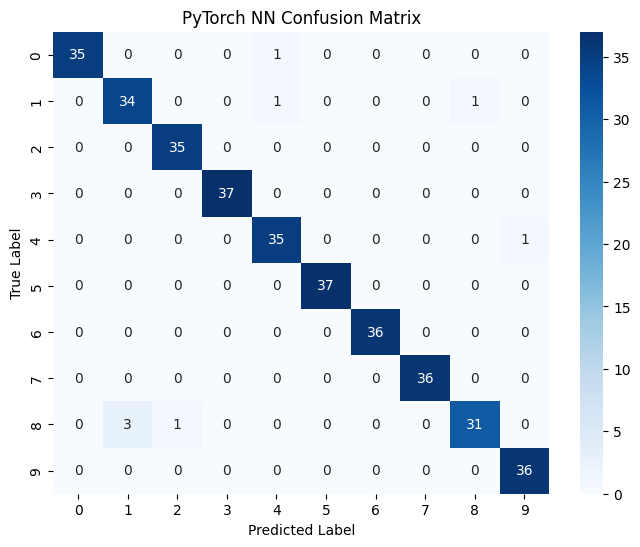

In [ ]:
print(f'\nPyTorch Neural Network Accuracy on Test Set: {accuracy_pt:.4f}')
print("Classification Report:\n", report_pt)
plot_confusion_matrix(all_labels_pt, all_preds_pt, digits.target_names, title='PyTorch NN Confusion Matrix')

In [ ]:
# @title 6. Model Comparison
# Display the accuracies of all models
print("\n--- Model Accuracy Comparison ---")
results_df = pd.DataFrame(list(model_results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False)
print(results_df)


--- Model Accuracy Comparison ---
                 Model  Accuracy
3           PyTorch NN  0.977778
0  Logistic Regression  0.972222
1        Random Forest  0.963889
2    Gradient Boosting  0.952778


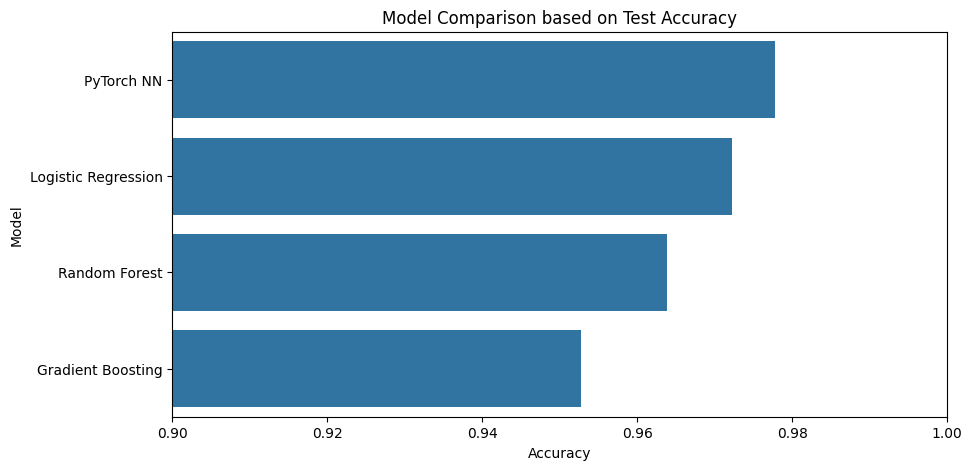

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Accuracy', y='Model', data=results_df)
plt.title('Model Comparison based on Test Accuracy')
plt.xlim(0.9, 1.0) # Adjust x-axis limits for better visualization
plt.show()

Based on these results, Logistic Regression and PyTorch NN often perform very well on this dataset.
Random Forest is  slightly less accurate. GBDT is also strong.

# 7. Saving the Best Performing Model (e.g., PyTorch NN) and Scaler

Let's choose the PyTorch model to save for the Streamlit app,
as it demonstrates saving/loading a more complex model type.
We also NEED to save the scaler used for preprocessing.

In [ ]:
# Create a directory to save models if it doesn't exist
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

In [ ]:
# --- Save the PyTorch Model State Dictionary ---
# The state_dict contains the learned weights and biases.
pytorch_model_path = os.path.join(model_dir, 'pytorch_digit_classifier.pth')
torch.save(pytorch_model.state_dict(), pytorch_model_path)
print(f"\nPyTorch model state_dict saved to: {pytorch_model_path}")
# IMPORTANT: To load this model later, you NEED the class definition (DigitClassifier).


PyTorch model state_dict saved to: saved_models/pytorch_digit_classifier.pth


In [ ]:
# --- Save the Scaler ---
# The scaler is crucial for preprocessing new data exactly like the training data.
scaler_path = os.path.join(model_dir, 'scaler.joblib')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

Scaler saved to: saved_models/scaler.joblib


--- (Optional) Save the Random Forest model (as an alternative) ---
rf_model_path = os.path.join(model_dir, 'random_forest_digits.joblib')
joblib.dump(rf_clf, rf_model_path)
print(f"Random Forest model saved to: {rf_model_path}")

In [ ]:
# --- Save test data indices for Streamlit (Optional but helpful) ---
# This allows Streamlit to easily pick samples from the *same* test set.
test_indices = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42, stratify=y)[1]
test_indices_path = os.path.join(model_dir, 'test_indices.npy')
np.save(test_indices_path, test_indices)
print(f"Test set indices saved to: {test_indices_path}")

Test set indices saved to: saved_models/test_indices.npy


# 8. Conclusion
In this notebook, we successfully:
1. Loaded and explored the `load_digits` dataset.
2. Preprocessed the data by splitting and scaling.
3. Trained and evaluated four different classification models:
   - Logistic Regression
   - Random Forest
   - Gradient Boosting (GBDT)
   - PyTorch Neural Network
4. Compared their performance using accuracy, classification reports, and confusion matrices.
5. Saved the trained PyTorch model's state dictionary and the data scaler for future use, specifically for a Streamlit application.

The next step is to build the Streamlit app to visualize predictions using the saved model and scaler.

In [ ]:
!pip install streamlit
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.9 MB/s eta 0:00:00


##2 Write the app.py file to the Colab environment:

You can use the "magic command" %%writefile to create the app.py directly in your Colab session. Just paste the code from the app.py in the previous response into a cell and add %%writefile app.py at the top. This will create a file named app.py in your Colab working directory. Remember to also download the saved_models folder and upload it into the Colab environment.

In [ ]:
%%writefile saved_models/app.py
import streamlit as st
import torch
import torch.nn as nn
import joblib
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import random
import os

# --- Configuration ---
MODEL_DIR = "saved_models"
MODEL_PATH = os.path.join(MODEL_DIR, "pytorch_digit_classifier.pth")
SCALER_PATH = os.path.join(MODEL_DIR, "scaler.joblib")
TEST_INDICES_PATH = os.path.join(MODEL_DIR, "test_indices.npy") # Optional path

# Check if model files exist
if not os.path.exists(MODEL_PATH) or not os.path.exists(SCALER_PATH):
    st.error(
        f"Error: Model file ('{MODEL_PATH}') or scaler file ('{SCALER_PATH}') not found."
        f" Please make sure the files are in the '{MODEL_DIR}' directory and you have run the Colab notebook to generate them."
    )
    st.stop() # Halt execution if files are missing

# --- PyTorch Model Definition ---
# IMPORTANT: This class definition MUST match the one used during training in Colab.
class DigitClassifier(nn.Module):
    def __init__(self, input_size=64, num_classes=10):
        super(DigitClassifier, self).__init__()
        self.layer_1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.layer_2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu1(x)
        x = self.layer_2(x)
        x = self.relu2(x)
        x = self.output_layer(x)
        return x

# --- Load Model and Scaler ---
@st.cache_resource # Cache resource loading for efficiency
def load_model_and_scaler():
    try:
        # Load the scaler
        scaler = joblib.load(SCALER_PATH)

        # Load the PyTorch model
        # Determine device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Instantiate the model structure
        model = DigitClassifier(input_size=64, num_classes=10)
        # Load the saved state dictionary
        # Map location ensures model loads correctly even if trained on GPU and run on CPU
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        model.to(device) # Move model to the appropriate device
        model.eval() # Set the model to evaluation mode
        print(f"Model loaded onto device: {device}")

        return model, scaler, device
    except FileNotFoundError as e:
        st.error(f"Error loading files: {e}. Make sure '{MODEL_PATH}' and '{SCALER_PATH}' exist.")
        st.stop()
    except Exception as e:
        st.error(f"An unexpected error occurred during loading: {e}")
        st.stop()

model, scaler, device = load_model_and_scaler()

# --- Load Dataset (only needed for getting test samples) ---
@st.cache_data # Cache data loading
def load_data():
    digits = load_digits()
    X, y = digits.data, digits.target
    # Load the indices used for the test set in the Colab notebook
    try:
        test_indices = np.load(TEST_INDICES_PATH)
        X_test_orig = X[test_indices]
        y_test_orig = y[test_indices]
        return X_test_orig, y_test_orig, digits.target_names
    except FileNotFoundError:
        st.warning(f"Test indices file ('{TEST_INDICES_PATH}') not found. Falling back to random split (might differ slightly from Colab's test set).")
         # Fallback: Recreate a test split (less ideal as it might not match exactly)
        # Use the same random_state and test_size as in Colab for *best chance* of match
        _, X_test_orig, _, y_test_orig = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
            )
        return X_test_orig, y_test_orig, digits.target_names
    except Exception as e:
        st.error(f"An error occurred loading test data: {e}")
        st.stop()

X_test_original, y_test_original, class_names = load_data()

# --- Streamlit App UI ---
st.title("Handwritten Digit Recognition Demo")
st.write("Using a PyTorch Neural Network trained on the Scikit-learn `load_digits` dataset.")

# Use session state to keep track of the current index
if 'current_index' not in st.session_state:
    st.session_state.current_index = random.randint(0, len(X_test_original) - 1)

# Button to show a new random digit
if st.button("Show Random Digit"):
    st.session_state.current_index = random.randint(0, len(X_test_original) - 1)

# Get the selected data point
index = st.session_state.current_index
image_data = X_test_original[index] # Original, unscaled data for display
true_label = y_test_original[index]

# --- Preprocess the selected data point for prediction ---
# 1. Reshape to (1, 64) as scaler expects 2D array
image_data_reshaped = image_data.reshape(1, -1)
# 2. Scale using the loaded scaler
image_data_scaled = scaler.transform(image_data_reshaped)
# 3. Convert to PyTorch tensor
image_tensor = torch.tensor(image_data_scaled, dtype=torch.float32).to(device)

# --- Make Prediction ---
with torch.no_grad(): # Ensure gradients are not calculated
    output = model(image_tensor)
    probabilities = torch.softmax(output, dim=1) # Get probabilities
    predicted_label = torch.argmax(probabilities, dim=1).item() # Get the index of the max probability

# --- Display Results ---
col1, col2 = st.columns(2)

with col1:
    st.subheader("Digit Image")
    # Display the original image (reshape back to 8x8)
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(image_data.reshape(8, 8), cmap='gray_r', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    st.pyplot(fig)

with col2:
    st.subheader("Prediction")
    st.metric(label="True Label", value=f"{true_label}")
    st.metric(label="Predicted Label", value=f"{predicted_label}")

    if true_label == predicted_label:
        st.success("Prediction is Correct!")
    else:
        st.error("Prediction is Incorrect.")

# Display prediction probabilities (optional)
st.subheader("Prediction Probabilities")
prob_data = probabilities.cpu().numpy().flatten() # Move to CPU and flatten
prob_dict = {str(i): prob_data[i] for i in range(len(class_names))}
st.bar_chart(prob_dict)

st.write(f"Displaying test sample index: {index}")

Writing saved_models/app.py


Install localtunnel:

npm install -g localtunnel: This command uses npm (Node Package Manager) to install localtunnel globally in the Colab environment. localtunnel is a tool that exposes a local server to the public internet. The -g flag ensures that localtunnel is installed globally and accessible from any directory in the Colab environment. Colab provides a Node.js environment, which makes installing npm packages seamless.

In [ ]:
!npm install localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸
added 22 packages in 3s
⠸
⠸3 packages are looking for funding
⠸  run `npm fund` for details
⠸

Run the Streamlit app in the background and redirect logs:

In [ ]:
!streamlit run saved_models/app.py &>/content/logs.txt &

Print the Colab's Public IP Address:



In [ ]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 35.204.98.154


Expose the Streamlit app using localtunnel:

In [ ]:
!npx localtunnel --port 8501

⠙your url is: https://twenty-bottles-cheat.loca.lt
^C


Open that URL (the one provided by localtunnel) in your web browser. This will take you to your running Streamlit application. Put the password as your IP address obtained earlier.